# Table of Contents:
1. [Data](#data)

1. [Feature Engineering](#feature_engineering)

1. [Algorithms & Search](#alg_search)

1. [Evaluation Metrics](#metrics)

1. [Ensemble Learning](#ensemble)

1. [Final Model Selection and Evaluation](#final_model)

1. [Results](#results)

1. [Conclusion](#conclusion)

In [1]:
# Imports
import  numpy   as np
import  pandas  as pd
import  warnings
warnings.filterwarnings('ignore')


# Feature Engineering
from    category_encoders          import OneHotEncoder, OrdinalEncoder
from    sklearn.experimental       import enable_iterative_imputer
from    sklearn.impute             import IterativeImputer, SimpleImputer
from    sklearn.base               import TransformerMixin
from    sklearn.base               import BaseEstimator
from    sklearn.preprocessing      import QuantileTransformer, StandardScaler
from    sklearn.compose            import ColumnTransformer

# Cross Validation and PipeLine
from    sklearn.model_selection    import RandomizedSearchCV, cross_val_score
from    sklearn.pipeline           import Pipeline

# Models
from    sklearn.ensemble           import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier, \
                                          GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from    sklearn.neighbors          import KNeighborsClassifier
from    sklearn.linear_model       import LogisticRegression, SGDClassifier
from    sklearn.svm                import LinearSVC

# Model Evaluation
from    sklearn.metrics            import balanced_accuracy_score, f1_score, plot_confusion_matrix, precision_score, recall_score,accuracy_score
from    sklearn.inspection         import permutation_importance


# Hypothetical Scenario:
____
You are working as a data scientist in a recruiting firm. The goal of a recruiter in this firm is to successfully help someone, who is looking for a new job, get hired. However, the current system in place involves recruiters to randomly reach out to people on their list. This is an issue because only a third of the people on the list are actually looking for work. This leads to the recruiter wasting a large chunk of their time reaching out to dead-ends. How can you, as a data scientist, help better allocate the recruiter's time to focus primarily on people who are looking for a job?
_____
# Research Question:
_____
**Given information about an individual, can we predict whether or not they are currently looking for a new job?**
_________


# Data <a id='data'></a>
_________
**Note that our data is imbalanced. 33% of the observations have the target = 1.**

The data we will be looking at includes 11 different features:
#### Numerical Columns:
1. ```city_development_index``` : Float from 0-1
2. ```training_hours```: Number of hours trained

#### Categorical:
1. ```city```: 123 diff cities
2. ```gender```: 4 genders: 'Male', 'Female', 'Other', nan


#### Ordinal Categorical:
1.  ```enrolled_university```: 'no_enrollment', 'Full time course', nan, 'Part time course'
2.  ```education_level```: 'Graduate', 'Masters', 'High School', nan, 'Phd', 'Primary School'
3. ```company_size```: nan, '50-99', '<10', '10000+', '5000-9999', '1000-4999', '10/49','100-500', '500-999'
3. ```relevent_experience```: 'Has relevent experience', 'No relevent experience'
6. ```major_discipline```: 'STEM', 'Business Degree', nan, 'Arts', 'Humanities', 'No Major', 'Other'
8. ```last_new_job```: nan, 'never', 1,2,3,4, >4
7. ```company_type```: 'Early Stage Startup', 'Funded Startup', 'NGO', 'Other', 'Public Sector', 'Pvt Ltd', nan
4. ```last_new_job```: nan, 'never', 1,2,3,4, >4

#### Numerical/Categorical
1. ```experience```:  nan, <1, 1 through 20, >20

#### Target
1. ```target```: 1 = "Looking for a Job", 0 = "Not Looking for a Job"
__________

In [2]:
df = pd.read_csv('HR_Analytics/aug_train.csv')
y = df['target']  # Keep target in X for preprocessing
X = df.drop('target', axis=1)
X.shape, y.shape

((19158, 13), (19158,))

# Feature Engineering and Preprocessing Pipeline <a id='feature_engineering'></a>
   ____________
For this model, we divide our features into 2 main categories: Numerical and Categorical. This is in order to create a preprocessing pipeline that could correctly deal with missing values **in an appropriate way**. 
- **Categorical Preprocessing:** 
    1. The first step in this pipeline is to use a **```SimpleImputer```** to fill in the missing values (np.NaN) with "missing". Although there are many other strategies to use when filling in missing values, there could be underlying reasons in the data collection why an observation has missing data. Therefore, to simply fill in the missing values with the most_frequent of the data would be adding bias from us, the researcher. Without knowing more about why these values are np.nan, we can just fill in the value with "missing" for categorical features. 
    2. We then pipe this into a **```OneHotEncoder```** in order to encode each variable's values as a separate binary column.
    3. Note that after further testing, I've decided to OneHotEncode the ordinal features as well. I did not notice an impact on the model itself when mapping the ordinal features individually to their relative values.
    4. Note that after some EDA, I have noticed that some of the categorical features can be encoded with the OrdinalEncoder. However, this means that I need to create a custom class in order to properly label my features such that the OrdinalEncoder object can encode they way I envision (the default is alphabetically).
    
    
    
- **Numerical Preprocessing:**
    1. Instead of using a SimpleImputer, I choose to use an **```IterativeImputer```** instead. The IterativeImputer tries to mimic R's MICE package (Multivariate Imputation by Chained Equations). I decided to use this because I felt that it would be a better solution than the SimpleImputer because:
        1. Can't fill in the values with "missing" since that affects the pipeline when trying to standardize the columns.
        2. It is a step in dealing with the problem of increased noise due to imputation [source = https://en.wikipedia.org/wiki/Imputation_(statistics)]
    2. Next, we use a **```StandardScalar```** to normalize our data. Due to the fact that neither of my numerical columns have any severe outliers, this is preferred over a RobustScalar. In addition, the normalizing helps bring both features within a similar range.
    3. Finally, due to the fact that many ML algorithms can perform better when the numerical features have a Gaussian distribution, we use a **```QuantileTransformer```**

_________

In [3]:
class OrdinalHelper(BaseEstimator, TransformerMixin):
    """Changes the name of the values in the ordinal columns so that
       OrdinalEncoder can be used in our pipeline. (Which defaults to 
       alphabetical and there isn't an easy way to add a mapping per
       column)"""
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        '''
        Given our data, return a dictionary where the keys are the column
        names and the values are the mapping dictionary for that column.
        The mapping dictionary will first organize each columns unique values
        by the percent of them that result in target==1. Then it will assign 
        a new name for each unique value relative to its rank. This is because
        using OrdinalEncoder in a Pipeline defaults to sorting the unique values
        alphabetically.
        '''
        # Use the training data (always)
        temp_X = pd.read_csv('HR_Analytics/aug_train.csv')
        # Get only the columns we care about
        global ord_cols
        col_needed = ord_cols + ['target']
        temp_X = temp_X[col_needed]
        # Need to impute it here (There are some redundancies in my code, but this was the 
        # simplest way to make sure that I wasn't doing any data leakage in my final model)
        sc = SimpleImputer(missing_values=np.nan, fill_value='missing', strategy="constant")
        temp_X = sc.fit_transform(temp_X)
        temp_X = pd.DataFrame(temp_X)#
        # Create mapping scheme
        ordinal_col_mapping = []
        name_mapping = {}
        for col in temp_X.columns[:-1]:
            temp_dic = {}
            temp_dic['col'] = col
            val_count = []  # Set of unique value, count in X[col]
            for val in temp_X[col].unique():
                # Get the P(target=1|X[col]==val)
                target_true = np.sum(temp_X.loc[np.where(temp_X[col] == val)][len(temp_X.columns)-1])\
                                /len(temp_X.loc[np.where(temp_X[col] == val)][len(temp_X.columns)-1])
                val_count.append((val, target_true))
            # Sort val_count (ascending):
            val_count.sort(key=lambda x: x[1])
            mapping = {}
            for index, tup in enumerate(val_count):
                mapping[tup[0]] = chr(97+index) + tup[0]
            name_mapping[col] = mapping
        self.mapping = name_mapping
        return self


    def transform(self, X, y=None):
        for row_index, row in enumerate(X):
            for col_index, val in enumerate(row):
                X[row_index, col_index] = self.mapping[col_index][val]
        return X

In [4]:
# Our categorical column we want to OneHotEncoder
cat_cols = ['city', 'gender'] 


ord_cols = ['enrolled_university', 'major_discipline', 'experience', 'last_new_job', 
            'company_type', 'company_size', 'education_level', 'relevent_experience']

# Our numerical columns
num_cols = ['city_development_index', 'training_hours']


# Ordinal Pipeline
ord_pipe = Pipeline([("impute", SimpleImputer(missing_values=np.nan, fill_value='missing', strategy="constant")),
                     ("encode", OrdinalHelper()),
                     ('ordinal', OrdinalEncoder(handle_unknown='ignore'))])

# Categorical Pipeline
cat_pipe = Pipeline([("impute", SimpleImputer(missing_values=np.nan, fill_value='missing', strategy="constant")),
                     ("encode", OneHotEncoder())])


# Numerical Pipeline
num_pipe = Pipeline([("impute", IterativeImputer(missing_values=np.nan, max_iter=10, initial_strategy="median")),
                        ("scaler", StandardScaler()),
                     ("transformer", QuantileTransformer(output_distribution='normal'))])

# Group them together with ColumnTransformer
preprocessing = ColumnTransformer([('categorical', cat_pipe, cat_cols),
                                   ('ordinal', ord_pipe, ord_cols),
                                   ('numerical', num_pipe, num_cols)])



# Algorithms & Search <a id='alg_search'></a>
_______
For this section, I chose a few algorithms to include in my __```RandomizedSearchCV```__:
   1. **```RandomForestClassifier```**
       1. Why: This was a ML model that I learned in my Intro to ML class. It seemed like a very good contester for this problem because it uses multiple decision trees (that individually tend to overfit on training data) and aggregates their predictions in order to decrease the variance of the model.
       2. Hyperparamater Tuning:
           - **Min Samples Leaf**: ```np.linspace(1,30,4)```
               - Min samples per leaf is a good hyperparameter to help each decision tree make more generalizable predictions. Note that the default is 1, which can lead to decision trees overfitting to the training data.
           - **Bootstrap**: ```[True, False]```
               - When Bootstrap is True, it means that each decision tree is shown a sample of the training data. This is an attempt to create "dumber" decision trees in order to have a better, generalized model. Note that this parameter is dependent on **max_samples** which we set to a small k (between 5 and 20). 
           - **Class Weight**: ```[None, 'balanced', 'balanced_subsample']```
               - Since our data is imbalanced, we want to include a variety of class_weights. Note that our SMOTE preprocessing step helps correct for this imbalance already. Therefore, I can expect the ideal class_weight to be None. This is more so a sanity check for me. 
           - **Number of Estimators**: ```np.linspace(50,500,4)```
              - Here I choose a variety of different number of estimators. These represent the number of decision trees that make up our "RandomForest". The larger the number can potentially lead to decreasing the variance of our model. 
              
              
   2. **```LinearSVC```**
       1. Why: Since this is a binary problem (we are predicting 1s and 0s), SVM can perform better than RandomForests (which is intrinsically situated for multi-class problems). In addition, SVM models can also have an advantage to more sparse data, which, with the OneHotEncoder, could prove to be useful. Finally, I decided to use a LinearSVC because it trains much quicker than the traditional SVC.
           ![As we can see in the above image, SVC is extremely slow](Images/SGD_Comparison.png)
                               - As we can see in the above image, SVC is extremely slow
       
       2. Hyperparameter Tuning:
           - **Class Weight**: ```['balanced', None]```
               - Similarly to my decision in RFClassification, I include both 'balanced' and None for the class weight of my SVC model
           - **C**: ```np.linspace(0.001, 10, 10)```
               - In an attempt to test different regularization weights, I set C to values between 1 and 100.
       
       
   3. **```KNeighborsClassifier```**
       1. Why: I included KNN because I felt like it was a fairly different algorithm from the Trees and could be interesting to see how it performs. 
       2. Hyperparameter Tuning:
           - **Number of Neighbors**: ```np.linspace(3, 13, 3)```
               - Tweaking the number of neighbors impacts the amount of neighbors we need to look at before classifying our observation.
           - **Weights**: ```['uniform', 'distance']```
               - Distance: Closer neighbors will have a higher influence on the classification than further neighbors.
               - Uniform: Both close and far neighbors have the same weight.
           - **p**: ```[1,2]```
               - p = 1 -> Manhattan Distance
               - p = 2 -> Euclidean distance
               
               
   4. **```ExtraTreesClassifier```**
       1. Why: This has a much faster implementation than RandomForestClassifier. This is due to the fact that ExtraTrees chooses its split point threshold's randomly versus RandomForest's more iterative approach.
       2. Hyperparameter Tuning:
           - This has the same hyperparameter tuning decisions as my RandomForestClassifier
           
           
   5. **```LogisticRegression```**
       1. Why: I included logistic regression in order to see how it performs vs. RandomForest. Logistic Regression, in general, is much quicker to train and much easier to interpret than Random Forests.
       2. Hyperparameter Tuning:
           - **Class Weight**: ```['balanced', None]```
               - Similarly to my decision in RFClassification, I include both 'balanced' and None for the class weight of my LogisticRegression model
           - **Solver**: ```['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']```
               - I included a variety of different solvers as these tend to be data-dependent and it is good to try a variety. Note that since my problem is not a multiclass problem, I am able to include all of these solvers.
           - **Penalty**: ```['l1', 'l2', 'elasticnet', 'none']```
               - This represents the penalty used in my loss function.
               
_______

# Evaluation Metrics <a id='metrics'></a>
__________
I decided to use a **weighted f1 score** as my metric since my data is imbalanced. In addition, it is equally important for a business, who cares about this research question, to correctly predict those looking for work (Precision) while maintaining a high Recall Rate (we aren't missing potential job-seeking individuals). This priority is due to a focus on resource allocation. If a business wants to reach out to individuals that are currently looking for jobs, we want to use a model that efficiently allocates their resources (recruiters) by avoiding reaching out to False Positives and making sure we don't miss any True Positives.

In [5]:
# Helper class
class DummyEstimator(BaseEstimator):
    "Pass through class, methods are present but do nothing."
    def fit(self): pass
    def score(self): pass

In [6]:
np.random.seed(1)  # Use a random seed to have consistent results

pipe = Pipeline([("preprocessing", preprocessing),
                 ("clf", DummyEstimator())])

search_space = [
            {'clf': [ExtraTreesClassifier(n_jobs=-1)], 
                'clf__min_samples_leaf': np.linspace(1, 30, 4, dtype=int),
                'clf__bootstrap': [True, False],
                'clf__max_samples': [5, 13, 20, 500], 
                'clf__class_weight': [None, 'balanced', 'balanced_subsample'],
                'clf__n_estimators': np.linspace(50, 500, 4, dtype=int)},
                
            {'clf': [RandomForestClassifier(n_jobs=-1)], 
                'clf__min_samples_leaf': np.linspace(1, 10, 4, dtype=int),
                'clf__bootstrap': [True, False],
                'clf__max_samples': [5, 13, 20] ,
                'clf__class_weight': [None, 'balanced', 'balanced_subsample'],
                'clf__n_estimators': np.linspace(50, 300, 4, dtype=int)},
               
            {'clf': [KNeighborsClassifier(n_jobs=-1)],
                'clf__n_neighbors': np.linspace(3, 13, 3, dtype=int),
                'clf__weights': ['uniform', 'distance'],
                'clf__p': [1,2]},
               
            {'clf': [LinearSVC()],  
                'clf__class_weight': ['balanced', None],
                'clf__C': np.linspace(0.001, 10, 10)},
               
            {'clf': [LogisticRegression(n_jobs=-1)],  
                'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                'clf__class_weight': ['balanced', None],
                'clf__penalty': ['l1', 'l2', 'elasticnet', 'none']},

            {'clf': [SGDClassifier(n_jobs=-1)],  
                'clf__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
                'clf__class_weight': ['balanced', None],
                'clf__penalty': ['l1', 'l2', 'elasticnet']}]

# Create grid search 
gs = RandomizedSearchCV(pipe, 
                        search_space, 
                        scoring='f1_weighted',
                        n_iter=25,
                        cv=5,
                        n_jobs=-1,
                        error_score='raise')

gs.fit(X, y);

In [7]:
print(f'Best f1_weighted Score: {gs.best_score_:.3f}\n\nBest Model: {gs.best_params_["clf"]}')

Best f1_weighted Score: 0.80

Best Model: RandomForestClassifier(bootstrap=False, class_weight='balanced', max_samples=13,
                       min_samples_leaf=4, n_estimators=216, n_jobs=-1)


# RandomizedSearchCV Results: 
Best Model:
```python
RandomForestClassifier(bootstrap=False,  # No bootstrapping -> Each tree sees all data
                       class_weight='balanced',  # Good because our data is imbalanced
                       min_samples_leaf=4,  # Increasing can improve generalizability if we are overfitting
                       n_estimators=216,  # Plenty of trees to train
                       n_jobs=-1)
```
F1_Weighted Score: ```0.798```

Commentary:
- Class_weight being 'balanced_subsample' can be changed to 'balanced' because we are not bootstrapping. In addition, we can remove max_samples from the hyperparamter list.
- We notice that bootstrapping let to a worse cross-validated weighted-f1 score.
- In addition, our min_samples_leaf was 4, which helps weaken the individual decision trees, but increase model generalizability (decreases variance)
- The class_weight being balanced which makes sense because our data is imbalanced and the model needs to add weights to the different labels. This can lead to a higher recall score and a lower precision score.
   
_________
# Ensemble Learning <a id='ensemble'></a>
_______
In order to further improve our model, we can look into ensemble learning as a way to improve our metric (f1_weighted). Note that we will be primarily looking at:
1. VotingClassifier()
    - This is the simplest of the three as it simply combines multiple machine learning models and takes the most common prediction ("Hard Voting") or the probability-weighted average of the individual learners ("Soft Voting").
2. Bagging
    - Bagging is useful because it tends to reduce the time of each individual model and improve the overall generality. In addition, it can be used with a variety of different models.
3. Boosting
    - Boosting has shown a lot of promise in improving model metrics the most (at least what I've read online). Therefore, I predict that this may lead to my best evaluation metric.
________

In [8]:
# Helper Function for displaying results of cross_val_score
def print_val_score(res):
    mean   = np.mean(res)
    max_   = np.max(res)
    min_   = np.min(res)
    std    = np.std(res)
    median = np.median(res)
    print(f"Mean: {mean:.3f}  |  Min: {min_:.3f}  |  Median: {median:.3f}  |  Max: {max_:.3f}  |  Std: {std:.3f}")
    
    
# Calculate the general stats for our first model to have a way to compare other methods
rfc_clf =  RandomForestClassifier(bootstrap=False, 
                                  class_weight='balanced',
                                  min_samples_leaf=4, 
                                  n_estimators=216,
                                  n_jobs=-1)


pipe = Pipeline([('preprocessing', preprocessing),
                  ('model', rfc_clf)])

res = cross_val_score(pipe, X, y, cv=5, scoring='f1_weighted')
print_val_score(res)

Mean: 0.80  |  Min: 0.79  |  Median: 0.80  |  Max: 0.80  |  Std: 0.01


# Voting Classifier:
_______
In this section, I simply combine 3 different models that seemed to perform the best (through multiple iterations of my RandomizedSearchCV).

In [9]:
# Different Models that I will be using:
rfc_clf =  RandomForestClassifier(bootstrap=False, 
                                  class_weight='balanced',
                                  min_samples_leaf=4, 
                                  n_estimators=216,
                                  n_jobs=-1)

lr_clf  = LogisticRegression(class_weight='balanced', 
                             n_jobs=-1, 
                             solver='sag')

etc_clf = ExtraTreesClassifier(class_weight='balanced', 
                               max_samples=20,
                               min_samples_leaf=10, 
                               n_estimators=50, 
                               n_jobs=-1)


# Different pipelines
pipe1 = Pipeline([('preprocessing', preprocessing),
                  ('model', rfc_clf)])

pipe2 = Pipeline([('preprocessing', preprocessing),
                  ('model', lr_clf)])

pipe3= Pipeline([('preprocessing', preprocessing),
                  ('model', etc_clf)])


estimators = [('rfc', pipe1),
              ('lr', pipe2),
              ('etc', pipe3)]

# Initialize my VotingClassifier
voting_clf = VotingClassifier(estimators = estimators,
                                  voting = 'soft',)

# Use Cross_val_score to see how well my model performs:
res = cross_val_score(voting_clf, X, y, cv=5, scoring='f1_weighted')

print_val_score(res)

Mean: 0.79  |  Min: 0.78  |  Median: 0.79  |  Max: 0.80  |  Std: 0.01


## VotingClassifier Results:
    - As we can see, our weighted f1 score is pretty close to how our single RandomForestClassifier performed.
    - It doesn't look like there is much significant difference, therefore we can move on to other ensemble techniques  
_________
# Bagging:
___________
In this section, I experiment the use of bagging with my RandomForestClassifier 

In [10]:
rfc_clf = RandomForestClassifier(bootstrap=False,
                                 class_weight='balanced',
                                 min_samples_leaf=4,
                                 n_estimators=216,
                                 n_jobs=-1)

bag = BaggingClassifier(rfc_clf,
                        n_estimators=11,
                        max_samples=0.8,
                        max_features=0.9,
                        oob_score=True)

bagging_pipe = Pipeline([('preprocessing', preprocessing),
                         ('model', bag)])

res = cross_val_score(bagging_pipe, X, y, cv=5, scoring='f1_weighted')

print_val_score(res)

Mean: 0.80  |  Min: 0.79  |  Median: 0.80  |  Max: 0.81  |  Std: 0.01


## Bagging Results:
    - Similarly to VotingClassifier, the Bagging did not substantially improve the model's performance, nor did it improve the model's predictive variance. In other words, bagging did not lead to more consistent results (aka: smaller standard deviation)
    
_______
# Boosting
In this section, will look at implementing a gradient boosting machine, specifically using a GradientBoostingClassifier as my final estimator in my StackingClassifier.

__________
### GradientBoostingClassifier

In [11]:
final_estimator = GradientBoostingClassifier()

estimators = [('rfc', pipe1),
              ('lr', pipe2),
              ('etc', pipe3)]


reg = StackingClassifier(estimators=estimators,
                        final_estimator=final_estimator, 
                         n_jobs=-1)

res = cross_val_score(reg, X, y, cv=5, scoring='f1_weighted')

print_val_score(res)

Mean: 0.80  |  Min: 0.80  |  Median: 0.80  |  Max: 0.81  |  Std: 0.01


## Ensemble Model Results:

1. VotingClassifier():
    - Using RandomForestClassifier, LogisticRegression, and ExtraTreesClassifier, this strategy yielded similar results to my initial RandomForestClassifier.
    - Note that I used a 'soft' scoring since every one of my models include probabilities to serve as a metric of confidence in a prediction.
    - I decided to not use this method for my final model because it did not perform significantly better than my initial model.
    
    
2. Bagging:
    - Similarly to VotingClassifier, this ensemble method did not do significantly better than my simpler model (1 RandomForestClassifier).


3. GradientBoostingClassifier():
    - This strategy, using a GradientBoostingClassifier as my final_estimator in a StackingClassifier gave me my best f1_weighted score. Therefore, I am going to use this as my final model. Note that the 3 estimators from my VotingClassifier() were used as the first step in my stackingClassifier.
___________

# Final Model Selection <a id='final_model'></a>
___________
I decided to use a StackingClassifier with the 3 estimators from my VotingClassifier and a GradientBoostingClassifier as my final estimator. This decision took into consideration the longer training time and considered that the increase in my weighted f1_score made it worth it.
_______
## Specifications of the Final Model:


Our final model included a **GradientBoostingClassifier** as our final estimator in a **StackingClassifier**.
The way a StackingClassifier works is that it takes in a number of estimators that will output their results as the input of our GradientBoostingClassifier (which trains a default of 100 decision stumps). Now, for the inputs: 
1. Estimator 1:
   - This model was my initial model that outperformed the other models I tested in my RandomizedSearchCV
   - Note that the hyperparameters for the RandomForestClassifier were chosen through a RandomizedSearchCV explained in my Initial Model selection.
```python
RandomForestClassifier(bootstrap=False,  # Don't bootstrap (each tree is trained on all data)
                       class_weight='balanced',  # Imbalanced data
                       min_samples_leaf=4,  # Increasing can improve generalizability if we are overfitting
                       n_estimators=216,  # Plenty of trees to try to reduce variability in predictions
                       n_jobs=-1)
    ```
2. Estimator 2:
    - A LogisticRegression model was used in addition to add a more variety of models. These hyperparameters were chosen based off of rerunning my RandomizedSearchCV until I got different models from the RandomForestClassifier.
```python
LogisticRegression(class_weight='balanced',  # Imbalanced data
                   n_jobs=-1, 
                   solver='sag')  # sag gives us a faster convergence on normalized data
```
3. Estimator 3:
    -  An ExtraTreesClassifier was also used because it I wanted to include at least one model that involved bootstrapping data. In particular, this model trained 50 trees on 20 sample observations from the data. In addition, the default hyperparameter for max_features trains each tree on a subset of the features in the data. Setting min_samples_leaf to 10 can lead to more generalizable results as each tree is cut a bit shorter in order for them to better predict on observations it hasn't seen before. Note that these hyperparameters were chosen based off of rerunning my RandomizedSearchCV until I got different models from the RandomForestClassifier.
```python
ExtraTreesClassifier(class_weight='balanced',  # Imbalanced data
                     max_samples=20,  # Train each tree on a sample of 20 observations
                     min_samples_leaf=10,  # Increasing can improve generalizability if we are overfitting
                     n_estimators=50,  # Number of trees to create in our classifier
                     n_jobs=-1)
```
_________
**All together**:
```python
final_estimator = GradientBoostingClassifier()  # Default hyperparameters

reg = StackingClassifier(estimators=estimators,  # The individual estimators explained above
                         final_estimator=final_estimator, 
                         n_jobs=-1)

```
_________

**But wait, there's more!**
In order to fit our StackingClassifier on the data, we needed to first include our preprocessing steps.

This involved:
   1. Ranking some ordinal features by their relative probabilities of having the target variable = 1.
       - Note that this is something I wanted to test to see how it would impact my final result. It is not common practice to use this method. Instead, when encoding ordinal features, we define the order heuristically. For example:
           - Say we have a feature, Education, with 3 categories: High School, Masters, PhD. The traditional way would be to either OneHotEncode them or encode them with their order of difficulty to acquire (High School -> 1, Masters -> 2, PhD -> 3). My method involved looking at each category and seeing which had the highest probability of having our target=1 (the individual is currently looking for work). With that information, we can rank them in that order, where higher numbers signify that they are **more** likely to be looking for work than lower numbers.
   2. Using OneHotEncoding on both 'city' and 'gender' after imputing "missing" values anywhere the data is not collected.
   3. Imputing the median for the numerical values, scaling them, and then changing their distribution into a Gaussian one.

       
______
## Evaluating the Final Model <a id='results'></a>
Now that we have a final model, we can:
   1. Predict on the test set and see what our f1_weighted score is.
   2. Look at the confusion matrix of our predictions as well.
   3. Look at some feature importance since we are using a Tree-based algorithm.
_______
**First**, we need to load in our testing data.

In [12]:
X_test = pd.read_csv('HR_Analytics/aug_test.csv')
y_test = np.load('HR_Analytics/aug_test_y.npy')

### 1. Train our model on all of the training data and then see how it performs on the test data

In [13]:
np.random.seed(1)  # Consistent results

# Different Models that I will be using:
rfc_clf =  RandomForestClassifier(bootstrap=False, 
                                  class_weight='balanced',
                                  min_samples_leaf=4, 
                                  n_estimators=216,
                                  n_jobs=-1)

lr_clf  = LogisticRegression(class_weight='balanced', 
                             n_jobs=-1, 
                             solver='sag')

etc_clf = ExtraTreesClassifier(class_weight='balanced', 
                               max_samples=20,
                               min_samples_leaf=10, 
                               n_estimators=50, 
                               n_jobs=-1)

# Different pipelines
pipe1 = Pipeline([('preprocessing', preprocessing),
                  ('model', rfc_clf)])

pipe2 = Pipeline([('preprocessing', preprocessing),
                  ('model', lr_clf)])

pipe3= Pipeline([('preprocessing', preprocessing),
                  ('model', etc_clf)])


estimators = [('rfc', pipe1),
              ('lr', pipe2),
              ('etc', pipe3)]

reg = StackingClassifier(estimators=estimators,
                        final_estimator=GradientBoostingClassifier(), 
                         n_jobs=-1)
reg.fit(X,y);

In [14]:
y_pred = reg.predict(X_test)
print(f"Weighted f1_Score = {f1_score(y_test, y_pred, average='weighted'):.3f}")

Weighted f1_Score = 0.80


**Result**: As we can see, our model has a **weighted f1-score of 0.795** on our testing set, which is around the same as the training set. This is a good sign because it can imply that our model might not have been overfit on the training and that it generalizes on new data just as well as data it was trained on.
__________
### 2. View the confusion matrix of our predictions and calculate the accuracy, recall and precision scores.

Recall Score: 0.64  |  Precision Score: 0.62  |  f1 Weighted Score: 0.80


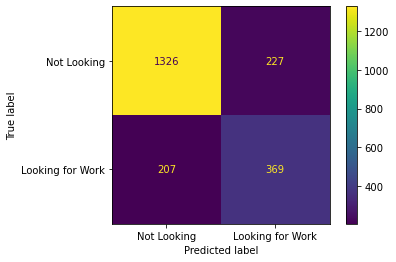

In [15]:
plot_confusion_matrix(reg, 
                      X_test, 
                      y_test,
                      display_labels=['Not Looking', 'Looking for Work']);


rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)

print(f"Recall Score: {rec:.2f}  |  Precision Score: {prec:.2f}",\
     f" |  f1 Weighted Score: {f1_score(y_test, y_pred, average='weighted'):.2f}");

#### Interpretation:
1. Looking at the confusion matrix, we see that our model did fairly well. In particular, our model misclassified only 14% of individuals not looking for work, and 37% of individuals looking for work.


2. In particular, our precision score was 62%, which means that **"When my model predicted someone to be Looking for Work, it was accurate 62% of the time."**. Although this isn't an amazing score, it can still be useful for a variety of potential business cases. In the narrative that we are using this model to help better allocate the time of our recruiters, having a 62% chance that every candidate the recruiter is talking to is looking for a job, can be a huge time saver. This is compared to not using the model and having only a 33% chance of reaching out to someone at random and them currently looking for work.


3. In addition, we can look at the recall score. At 63%, this means that **"When an individual was looking for work, our model accurately classified them 63% of the time."** This is also an important metric for the above business situation. In particular, we would want to minimize our False Negatives, aka: when our model inaccurately predicts someone who is looking for work.


4. All together, we can look at the weighted f1 score of **79%** because our business case revolves around maximizing both precision and recall. Note that since this is an imbalanced dataset, our f1 score calculates the metric for each label, weighs it proportionally to its relative frequency, and outputs a score that, in this case, is not in-between the recall and precision score. 
______
### 3. Feature Importance.
For interpretability, it is always important to try to extract feature importance from a model. In other words, what features were deemed the "most important" for our model. For this task, I use sklearn's built-in permutation_importance over 100 iterations

In [16]:
np.random.seed(1)
r = permutation_importance(reg, X_test, y_test,
                           n_repeats=100)

print(f"{'Feature':^25}{'Mean':^8}{'std':^13}")
print('-'*(25+8+13))
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X.columns[i]:<25}",\
              f"{r.importances_mean[i]:.2f}",\
              f" +/- {r.importances_std[i]:.2f}")

         Feature           Mean       std     
----------------------------------------------
city_development_index    0.05  +/- 0.01
city                      0.04  +/- 0.01
company_size              0.02  +/- 0.00
company_type              0.02  +/- 0.00
education_level           0.01  +/- 0.00
relevent_experience       0.01  +/- 0.00
enrolled_university       0.00  +/- 0.00


#### Results:
1. Interestingly enough, it looks like the city_development_index is the most impactful when making this prediction. In order to better understand the relationship between city_development_index and the target variable, it is helpful to look at a quick plot:

<img src="Images/EDA_City_Development_Index.png" alt="Drawing" style="width: 400px;"/>

2. As we can see, it looks like as the city_development_index increases, people are less likely to be looking for a job. This makes sense as a higher city development index could mean that people are more content with their current location. Note that this assumes that looking for work tends to be a factor of location as well as things related to your current job (job type, company size, etc). In addition, this graph could be interpreted on the flip-side. People in cities with a low development index are much more likely to be seeking a new job.

3. Besides city_development_index, the city, company_size and major_discipline also had a relatively high impact.

_________
# Conclusion: <a id='conclusion'></a>  

## Summary:
With a goal of implementing a variety of skills learned in my Machine Learning Lab, this project focused on HR data to help identify whether or not someone is currently looking for a job. After extensive EDA, I decided to construct three separate pipelines for preprocessing: one for each type of feature (numerical, categorical, ordinal). Next, although my data was imbalanced, I decided against using oversampling with SMOTE because it didn't lead to a noticeable improvement (as shown with cross validation). Finally, I tried several of ensemble techniques and decided that my final model would be a StackingClassifer with a variety of estimators derived from my RandomizedSearchCV and a GradientBoostingClassifier as my final estimator. Note that I used a weighted f1 score as my metric to compare models with as it equally values precision and recall scores while taking into consideration that the data is imbalanced.

## Common Questions:
1. **Why does any of this matter?**
    - **I am glad you asked!** Although this project was primarily as a tool to explore different modeling methods on fairly clean data, we did it in a way focusing on a hypothetical scenario where this data would be used. This is helpful when working on actual business problems, because it is important to iterative over different models and have a consistent and **relevant** metric that we compare each model with. This metric is relevant to the business use-case.


2. **Why did I impute categorical variables to be "missing" instead of "most_frequent"?**
   - I chose to do this because imputing the most_frequent can add bias to our model. In essence, we are assuming that the entry was empty because of a clerical error, which could, in itself, have an impact on our target variable. One could argue that me imputing "missing" could be adding my own bias that these weren't just clerical errors and have an equally negative impact on our model. In the end, it was personal preference.
   - **Follow up: Why did I not impute missing for numerical as well?**
       - With numerical data, we need slightly different imputing strategies. This is because we want our end result to be all numerical. Therefore, I chose to use an IterativeImputer which I explain below.


3. **How did I decide to using my own ordinal encoding?**
    - After noticing that a lot of the categories had some inherent order to them, I was interested to see if I could find a relationship with a given value and an improved chance of signifying whether an observation is "Looking for a Job" (target == 1). I did this by calculating the relative probability that each column (other than 'city', 'gender', and the numerical columns) leads to the target being 1.
\begin{equation}
P(target = 1 | X[col] = val) 
\text{  For col in ordinal columns, val in unique values in X[col]}
\end{equation}


4. **Why did I use an IterativeImputer for my numerical data?**
    - This decision was made primarily because I did not want to have a single rule of only imputing the median. Instead, an IterativeImputer works in the following way:
        - Say you have 4 columns ('a', 'b', 'c', 'd') and one column ('d') is missing some values. An iterative imputer will train a new model trying to predict the missing values in 'd' with the values in ('a', 'b', 'c').


5. **Why did I use a QuantileTransformer on my numerical data?**
    - "Many machine learning algorithms prefer or perform better when numerical variables have a Gaussian or standard probability distribution." (https://machinelearningmastery.com/quantile-transforms-for-machine-learning/). In particular, I included a LogisticRegression model in my RandomizedSearchCV which assumes that the data is normalized.


6. **Why did I use cross_val_score?**
    - I decided to use cross_val_score because I felt that it was a better route of getting a good sense of how well a model performs in order to properly compare it to other modeling strategies.
    
    
7. **Why did I decide to use the StackingClassifier()?**
   - Simply put, it had a better cross validation score than any other model.


## Future Steps
1. As Boosting has taken Kaggle competitions by stride, it would be interesting to see more exploration on how boosting can further improve this model. In particular, I am interested to see how XGBoost and CatBoost can be used to solve this problem.
2. Further exploration on other feature engineering techniques that could improve predictability.